In [2]:
using JSON
using LinearAlgebra
using SparseArrays
using StatsBase
using Distributions
using Plots

# Some conceptual background

Covariance estimation is challenging, and the difficulty increases with the dimension of the data.

However, consider this unusual situation:

* We assume the precision matrix (inverse covariance matrix) \\( \Omega \\) is a linear combination of sparse symmetric positive definite *basis matrices* \\(\Omega_1, \ldots, \Omega_k\\).
* We assume the sparse precision matrices \\(\Omega_1, \ldots, \Omega_K\\) have little off-diagonal "overlap" with each other. I.e., there exist relatively few indices \\( (i,j) \\) such that multiple basis matrices have nonzero entries at \\( (i,j) \\).

In this special case, covariance estimation reduces to finding \\( \alpha_1, \ldots, \alpha_K \\), the coefficients of the linear combination \\( \Omega = \sum_k \alpha_k \Omega_k \\). 

Furthermore: under these circumstances, increasing the dimension of the data actually *improves* our ability to estimate covariance. Each new dimension yields more information about the relative contributions of the different basis matrices.

## (Approximate) Method of Moments

If we try a Maximum Likelihood approach, we end up with this mystifying first-order-sufficient condition:

\\( \sum_{m,n} \left[ (\sum_k \alpha_k \Omega_k )^{-1} \right]_{m,n} \cdot \left[ \Omega_i \right]_{m,n} = x^T \Omega_i x ~ ~ \forall i \in [K] \\)

This is satisfied if 

\\( (\sum_k \alpha_k \Omega_k )^{-1} = x x^T\\).

However, it isn't straightforward to find the \\(\alpha_k \\) satisfying that expression.
Solving it via gradient descent would be prohibitively expensive -- computing the gradient would entail inverting a large matrix at every step.

Alternatively we can convert this to a **Method of Moments** estimator by seeking \\( \alpha_1, \ldots, \alpha_K \\) satisfying 

\\( \sum_k \alpha_k \Omega_k  = \left[\lambda x x^T + (1 - \lambda) \sigma^2 I \right]^{-1} \\)

where \\( \lambda \in [0,1) \\). That is, we make the empirical covariance invertible and set its inverse to a linear combination of the basis matrices.

We can write the inverse on the RHS in closed form:

\\(\frac{1}{\sigma^2 (1 - \lambda)} \left[ I  - \frac{\lambda}{\lambda x^\top x + (1 - \lambda) \sigma^2} x x^\top \right]\\) 


The equation is unlikely to have an exact solution.
However, we can solve it approximately in a least-squares sense.

## Let's simulate some data and see how this goes

In [ ]:
data_dim = 10000
n_pwys = 100
n_patients = 100
pwy_density = 0.0005;

In [ ]:
# Function for building a sparse, signed, undirected network (edge list)
function build_sparse_network(data_dim, density)
    n_edges = Int(round(density*data_dim*(data_dim - 1)*0.5))
    edges = Set{Pair{Int64,Int64}}()
    result = zeros(Int64, n_edges, 3)
    row = 1
    while row <= n_edges
        pair = collect(samplepair(data_dim))
        sort!(pair)
        pair_pair = (pair[1] => pair[2])
        if !(pair_pair in edges)
            push!(edges, pair[1] => pair[2])
            sgn = rand([-1,1])
            result[row,:] .= [pair[1], pair[2], sgn]
            row = row + 1
        end
    end
    
    return result
end

In [ ]:
# Build a list ("basis") of sparse, undirected networks
networks = [build_sparse_network(data_dim, pwy_density) for i=1:n_pwys]

In [ ]:
# Generate some "pathway activations"
activations = rand(Distributions.Exponential(4.0), n_pwys)

In [ ]:
# Generate a big fat precision matrix
off_diag_multiplier = 1.0
diag_multiplier = 400.0

function build_precision_matrix(networks, activations, data_dim)
    
    combined_edges = Set{Pair{Int64,Int64}}()
    for net in networks
        for i=1:size(net,1)
            push!(combined_edges, net[i,1] => net[i,2])
        end
    end
    encoder = collect(combined_edges)
    decoder = Dict([edge => i for (i, edge) in enumerate(encoder)])
    
    result_I = [edge.first for edge in encoder]
    result_J = [edge.second for edge in encoder]
    result_V = zeros(length(encoder))
    
    for (i, net) in enumerate(networks)
        for j=1:size(net,1)
            edge = (net[j,1] => net[j,2])
            result_idx = decoder[edge]
            result_V[result_idx] += net[j,3]*activations[i]*off_diag_multiplier
        end
    end
    
    result = Symmetric(sparse(result_I, result_J, result_V, data_dim, data_dim) + sparse(I,data_dim,data_dim)*diag_multiplier)
end


In [ ]:
prec = build_precision_matrix(networks, activations, data_dim)
# prec = prec + 200.0*sparse(I,dim,dim)

In [ ]:
# Sample some data from a MVN, parameterized by the big fat precision matrix
F = cholesky(prec)
z = randn(data_dim, n_patients)

X = F.UP\z

### Build the matrix of precision matrix entries

In [ ]:
function build_regression_features(networks)
    result = Dict{Pair{Int64,Int64},Vector{Float64}}()
    for (i,net) in enumerate(networks)
        for j=1:size(net,1)
            if net[j,1] == net[j,2]
                continue
            end
            edgepair = net[j,1]=>net[j,2]
            if !(edgepair in keys(result))
                result[edgepair] = zeros(size(networks,1))
            end
            result[edgepair][i] = net[j,3]
        end
    end
    
    result_idx = collect(keys(result))
    result_mat = zeros(length(result_idx),size(networks,1))
    for i=1:size(result_mat,1)
        result_mat[i,:] .= result[result_idx[i]]
    end
    return result_idx, result_mat
end

In [ ]:
regression_feat_idx, regression_feat = build_regression_features(networks)

### Compute entries of the empirical precision matrix

In [ ]:
function compute_empirical_prec(i, j, x, lambda, sigma_sq, denom, normsq)
    result =  -lambda * x[i]*x[j] / (lambda*normsq + denom)
    if i == j
        result += 1.0
    end
    return result/denom
end

function build_regression_target(reg_feat_idx, X, lambda, sigma_sq)
    result = zeros(size(reg_feat_idx,1), size(X,2))
    denom = (1.0 - lambda) * sigma_sq
    for j=1:size(X,2)
        normsq = dot(X[:,j],X[:,j])
        big_mult = -lambda /(lambda*normsq + denom)
        for (i,p) in enumerate(reg_feat_idx)
            result[i,j] = big_mult * X[p.first,j] * X[p.second,j]
        end
    end
    return result
end


function build_regression_target_new(reg_feat_idx, X, lambda)
    variances = var(X, dims=2)
    X_std = X ./ sqrt.(variances)
    X_shrunk = X ./ variances
    result = zeros(size(reg_feat_idx,1), size(X,2))
    denom = 1.0 - lambda
    for j=1:size(X,2)
        normsq = dot(X_std[:,j],X_std[:,j])
        big_mult = -lambda / ((lambda*normsq + denom) * denom)
        for (i,p) in enumerate(reg_feat_idx)
            result[i,j] = big_mult * X_shrunk[p.first,j] * X_shrunk[p.second,j]
        end
    end
    return result
end


function build_regression_target_bayesian(reg_feat_idx, X)
    variances = var(X, dims=2)
    X_std = X ./ sqrt.(variances)
    X_shrunk = X ./ variances
    result = zeros(size(reg_feat_idx,1), size(X,2))
    for j=1:size(X,2)
        normsq = dot(X_std[:,j],X_std[:,j])
        mult = - size(X,1) / normsq 
        for (i,pair) in enumerate(reg_feat_idx)
            result[i,j] = mult * X_shrunk[pair.first,j] * X_shrunk[pair.second,j]
        end
    end
    return result
end


### Build the vector of precision matrix entries

In [ ]:
# lambda = 1.0 - (1.0/size(X,1))
# B = build_regression_target_new(regression_feat_idx, X, lambda)

p = 0.1*n_pwys
B = build_regression_target_bayesian(regression_feat_idx, X)

In [ ]:
ip_mat = transpose(regression_feat) * regression_feat
Y = transpose(regression_feat) * B

In [ ]:
pred = ip_mat \ Y

In [ ]:
mean(activations ./ pred)

In [ ]:
scores = [corspearman(pred[:,i], activations) for i=1:n_patients]

In [ ]:
mean(scores)

# Let's try this on some real-world pathways and data

### Load some data

In [3]:
pwys = JSON.parsefile("../analyses/temp/pathways/TCGA.json");
data = JSON.parsefile("../analyses/temp/experimental_eval/data/TCGA.json");
pattern = JSON.parsefile("../analyses/temp/experimental_eval/observations/pwys=TCGA__test=0.1__rep=0.json");

### Convert data to matrices: 

In [4]:
data_matrix = transpose(hcat(data["data"]...))
# obs_idx = pattern["measured_train"]
# observed_data = data_matrix[:, obs_idx]
# obs_idx_set = Set(obs_idx)

# hidden_idx = [idx for idx=1:size(data_matrix,2) if !( idx in obs_idx_set )]
# hidden_data = 0.01 * randn(size(data_matrix,1), size(data_matrix,2) - size(obs_idx,1))

67×8661 Transpose{Float64,Array{Float64,2}}:
 NaN  NaN  NaN  NaN   0.0     …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN   0.0724     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN   0.6357     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN   0.3332     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN   0.4552     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN   0.0251  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN   0.059      NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN   0.024      NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  -0.0571     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  -0.3766     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  -0.042   …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN   0.0933     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN   0.0515     NaN  NaN  NaN  NaN  NaN  NaN  NaN
   ⋮                          ⋱         ⋮                        ⋮
 NaN  NaN  NaN  N

In [5]:
obs_idx_set = Set([i for i=1:size(data_matrix,2) if !isnan(data_matrix[1,i]) ]);

In [6]:
function moralize_graph(edge_arr)
    
    # Convert to a parent set representation
    parent_sets = Dict{Int64,Set{Pair{Int64,Int64}}}()
    
    for i=1:size(edge_arr,1)
        child = edge_arr[i,2]
        parent = edge_arr[i,1]
        weight = edge_arr[i,3]
        if child in keys(parent_sets)
            push!(parent_sets[child], parent => weight)
        else 
            parent_sets[child] = Set{Pair{Int64,Int64}}()
            push!(parent_sets[child], parent => weight)
        end
    end
    
    # Build the new undirected, moralized edge set
    new_edges = Dict{Pair{Int64,Int64},Int64}()
    for child in keys(parent_sets)
        
        # Add parent-child edges
        for p_w in parent_sets[child]
            parent = p_w.first
            weight = p_w.second
            if child < parent
                new_edges[child => parent] = weight
            else
                new_edges[parent => child] = weight
            end
        end
        
        # Add parent-parent edges
        # TODO: resolve duplicates in a deterministic fashion
        parent_vec = collect(parent_sets[child])
        for (i, p_w_i) in enumerate(parent_vec)
            parent_i = p_w_i.first
            weight_i = p_w_i.second
            for j=(i+1):length(parent_vec)
                p_w_j = parent_vec[j]
                parent_j = p_w_j.first
                weight_j = p_w_j.second
                
                # order these two parents
                if parent_i < parent_j
                    min_parent = parent_i
                    max_parent = parent_j
                else
                    min_parent = parent_j
                    max_parent = parent_i
                end
            
                if !((min_parent=>max_parent) in keys(new_edges))
                    new_edges[min_parent => max_parent] = weight_i*weight_j
                end
                
            end
        end
    end
       
    # return the results as an array
    result = zeros(Int64, length(new_edges), 3)
    for (i, (pair,weight)) in enumerate(new_edges)
        result[i,1] = pair.first
        result[i,2] = pair.second
        result[i,3] = weight
    end
    
    return result
end

moralize_graph (generic function with 1 method)

In [7]:
moralized_pwys = Vector{Matrix{Int64}}(undef,length(pwys["pathways"]))

for (i,pwy) in enumerate(pwys["pathways"])
    pwy_arr = transpose(hcat(pwy...))
    moralized_pwys[i] = moralize_graph(pwy_arr)
end
# pwy_1 = transpose(hcat(pwys["pathways"][1]...))

In [8]:
function build_combined_prec(eps, acts, pwys, dim)
   
    IJV = Dict{Pair{Int64,Int64},Float64}()
    
    for (k,pwy) in enumerate(pwys)
        for i=1:size(pwy,1)
            pair = (pwy[i,1] => pwy[i,2])
            
            # off-diagonal entries
            off_diag = acts[k]*pwy[i,3]
            if !(pair in keys(IJV))
                IJV[pair] = 0.0
                IJV[pair.second => pair.first] = 0.0
            end
            IJV[pair] += off_diag
            IJV[pair.second => pair.first] += off_diag
            
            # diagonal entries
            on_diag = acts[k]*pwy[i,3]*pwy[i,3]
            if !((pwy[i,1]=>pwy[i,1]) in keys(IJV))
                IJV[pwy[i,1]=>pwy[i,1]] = eps
            end
            IJV[pwy[i,1]=>pwy[i,1]] += on_diag
            
            if !((pwy[i,2]=>pwy[i,2]) in keys(IJV))
                IJV[pwy[i,2]=>pwy[i,2]] = eps
            end
            IJV[pwy[i,2]=>pwy[i,2]] += on_diag
        end
    end
    
    result_I = zeros(Int64, length(IJV))
    result_J = zeros(Int64, length(IJV))
    result_V = zeros(Float64, length(IJV))
    for (i,(k,v)) in enumerate(IJV)
        result_I[i] = k.first + 1
        result_J[i] = k.second + 1
        result_V[i] = v
    end
    
    println(minimum(result_I))
    println(maximum(result_I))
    println(dim)
    
    result = Symmetric(sparse(result_I, result_J, result_V, dim, dim))
    return result
end

build_combined_prec (generic function with 1 method)

In [ ]:
function restrict_graph(edge_arr, vertex_set)
    edge_idx = Set{Int64}()
    for i=1:size(edge_arr,1)
        if (edge_arr[i,1] in vertex_set) & (edge_arr[i,2] in vertex_set)
            push!(edge_idx, i)
        end
    end
    
    result = zeros(Int64, length(edge_idx), 3)
    for (i,idx) in enumerate(edge_idx)
        result[i,:] .= edge_arr[idx,:]
    end
    
    return result
end

In [9]:
activations = ones(size(moralized_pwys,1))
combined_prec = build_combined_prec(1e-5, activations, moralized_pwys, size(data_matrix,2));

1
8661
8661


In [12]:
function marginalize_prec(prec, keep_idx_set)
    marg_idx_set = setdiff(Set(1:size(prec,1)), keep_idx_set)
    marg_idx = sort(collect(marg_idx_set))
    keep_idx = sort(collect(keep_idx_set))
    prec = convert(Matrix, prec)
    YX = prec[marg_idx, keep_idx]
    return prec[keep_idx, keep_idx] - (transpose(YX)*(prec[marg_idx, marg_idx] \ YX))
#     return prec[keep_idx, keep_idx] - (transpose(YX) * YX)
end

marginalize_prec (generic function with 1 method)

In [13]:
marginalized = marginalize_prec(combined_prec, obs_idx_set)

3238×3238 Array{Float64,2}:
  2.76622      0.766212    -1.91382e-7  …   9.84679e-9  0.0       1.17906e-6
  0.766212     2.76624     -1.91382e-7      9.84679e-9  0.0       1.17906e-6
 -1.91382e-7  -1.91382e-7   1.92103        -5.37603e-7  0.0       1.17432e-8
 -1.91382e-7  -1.91382e-7   0.921019       -5.37603e-7  0.0       1.17432e-8
 -7.83874e-7  -7.83874e-7   1.95442e-7     -1.7277e-5   0.0      -9.26374e-8
 -7.83874e-7  -7.83874e-7   1.95442e-7  …  -1.7277e-5   0.0      -9.26374e-8
  0.0          0.0          0.0             0.0         0.0       0.0
 -3.20966e-7  -3.20966e-7  -9.80468e-9      2.44336e-9  0.0      -1.0613e-7
  1.69134e-7   1.69134e-7   6.09126e-8      2.44293e-7  0.0       3.76343e-8
  1.69134e-7   1.69134e-7   6.09126e-8      2.44293e-7  0.0       3.76343e-8
  1.00942e-6   1.00942e-6   1.28088e-7  …   4.04217e-7  0.0      -2.25231e-8
  1.00942e-6   1.00942e-6   1.28088e-7      4.04217e-7  0.0      -2.25231e-8
  0.0          0.0          0.0             0.0         

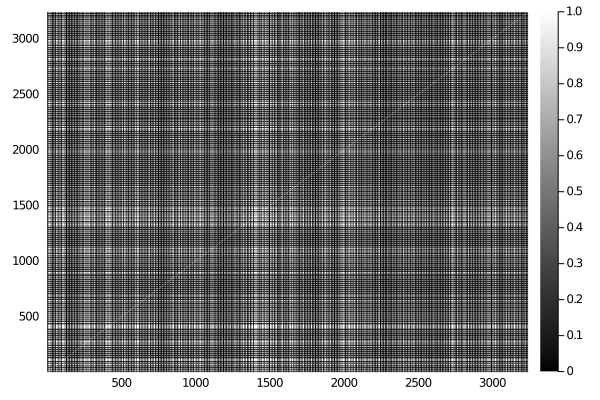

In [23]:
heatmap((abs.(marginalized) .> 0.0), color=:greys)

In [ ]:
restricted_pwys = [restrict_graph(pwy, obs_idx_set) for pwy in moralized_pwys]

In [ ]:
size_vec = [size(pwy,1) for pwy in restricted_pwys]

In [ ]:
p = "cat" => "dog"

In [ ]:
reverse(p)

In [ ]:
a = randn(10,10)

In [ ]:
a[[1,3,5,7],[2,4]]

In [ ]:
s1 = Set(["cat","dog","fish"])
s2 = Set(["fish"])

In [ ]:
setdiff(s1,s2)